<font size = 5>  Проект по сегментации пользователей банка по потреблению </font>

## Материалы

 * [Дашборд](https://public.tableau.com/app/profile/diana.legrand/viz/bank_clients_by_city/Dashboard3)
 * [Презентация](https://disk.yandex.ru/i/x7xjzpZTNpV7oA)

## Описание проекта

**Общее описание проблемной ситуации**: Каждый банк делит своих клиентов на различные сегменты в зависимости от того, какими продуктами и на какую сумму они пользуются. Например, это может быть градация mass, mass-affluent и affluent. Но на самом деле сегментация клиентов у каждого банка уникальная. «Метанпромбанк» хочет исследовать особенности клиенского поведения по банковским продуктам через призму своих сегментов и понять, насколько он успешен в работе с теми или иными клиентами.

В условиях нарастающей волатильности финансового рынка и общей неопределенности в развитии национальной экономики снижается доверие инвесторов, уменьшается объем депозитных операций в банках, нарастает доля "токсичных" активов и, как результат, падает показатель общей деловой активности. Даже в кризисных условиях эффективность банка достигается в первую очередь грамотным маркетингом: *правильный расчет таргет-группы и целевое предложение ей банковских услуг* являются залогом успешного развития банка.

Сегментирование позволяет установить количественные характеристики - число выделенных групп, их размер, тенденции развития, а также дает возможность вскрыть причинно-следственную связь поведения потребителей и позволяет на основе анализа признаков поведения выделить и описать условные их типы.

**Цель исследования**  - сегментировать банковских клиентов по потреблению для разработки мероприятий по удержанию клиентов.

**Задачи исследования**:
- Провести исследовательский анализ данных,
- Сегментировать пользователей на основе данных о количестве потребляемых продуктов,
- Сформулировать и проверить статистические гипотезы.
    
    * Проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.
    * Проверить гипотезу, что чем большим количеством продуктов пользуется клиент, тем ниже вероятность оттока.

## Описание данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import itertools
import requests
import re
import os
import math
from io import BytesIO

import scipy.stats as st

from statsmodels.stats.multitest import multipletests
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
#from clustergram import Clustergram
#import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.float_format', '{:,.2f}'.format) #настройки pandas для отображения чисел без лишних запятых
pd.set_option("max_colwidth", 200) #настройки pandas для отображения строк полностью

In [2]:
try:
    bank_data = pd.read_csv('/datasets/bank_dataset.csv')
except:
    bank_data  = pd.read_csv('D:/bank_dataset.csv')

In [3]:
bank_data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0


In [4]:
bank_data.tail()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,"96,270.64",0
9996,15612628,516,Ярославль,М,35,10,"57,369.61",1,1,1,"101,699.77",0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,"42,085.58",1
9998,15725091,772,Ростов Великий,М,42,3,"75,075.31",2,1,0,"92,888.52",1
9999,15671055,792,Ярославль,Ж,28,4,"130,142.79",1,1,0,"38,190.78",0


Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Предобработка данных

Проведем предобработку данных. 

In [5]:
def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('__([A-Z])', r'_\1', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

In [6]:
def preprocess_data(data, snake_case):
    if snake_case == True:
        snake_case_columns = []
        for column in data.columns:
            snake_case_columns.append(to_snake_case(column))
        data.columns = snake_case_columns
    
    print('\033[1m' + 'Info:' + '\033[0m')
    data.info()
    
    print()
    print('\033[1m' + 'Head:' + '\033[0m')
    display(data.head())
    
    print('\033[1m' + 'Shape:' + '\033[0m')
    display(data.shape)
    
    print('\033[1m' + 'Number of dublicated values:' + '\033[0m')
    display(data.duplicated().sum()) 
    
    print('\033[1m' + 'Number and Share of Missing values:' + '\033[0m')
    display(pd.concat([data.isna().sum(), data.isna().mean()], axis=1)\
            .rename(columns={0:'Количество пропусков', 1:'Доля'})\
            .style.format({'Количество пропусков':'{:.0f}', 'Доля':'{:.2%}'}))

In [7]:
preprocess_data(bank_data, True)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB

Head:


,userid,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0


Shape:


(10000, 12)

Number of dublicated values:


0

Number and Share of Missing values:


,Количество пропусков,Доля
userid,0,0.00%
score,0,0.00%
city,0,0.00%
gender,0,0.00%
age,0,0.00%
objects,0,0.00%
balance,3617,36.17%
products,0,0.00%
credit_card,0,0.00%
loyalty,0,0.00%


### Корректировка названий колонок

Итак, датасет содержит 10 000 строк. Названия колонок были приведены к snake_case (поправим только столбец userid).

In [8]:
bank_data = bank_data.rename(columns={'userid':'user_id'})

### Работа с дубликатами

Дубликатов в датасете нет.

### Работа с пропущенными значениями

Пропущенные значения есть только в столбце balance, их доля - **36,17%**.

In [9]:
bank_data.query('balance.isnull() == True', engine='python').head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,"10,062.80",0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,"76,390.01",0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,"26,260.98",0


In [10]:
bank_data.query('balance.isnull() == True', engine='python').describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,"3,617.00","3,617.00","3,617.00","3,617.00",0.00,"3,617.00","3,617.00","3,617.00","3,617.00","3,617.00"
mean,"15,734,685.59",649.45,38.43,5.07,NaN,1.78,0.72,0.52,"98,983.56",0.14
std,"71,947.49",96.16,10.49,2.86,NaN,0.50,0.45,0.50,"57,730.83",0.35
min,"15,608,442.00",350.00,18.00,0.00,NaN,1.00,0.00,0.00,90.07,0.00
25%,"15,672,255.00",583.00,31.00,3.00,NaN,1.00,0.00,0.00,"49,506.82",0.00
50%,"15,736,083.00",651.00,37.00,5.00,NaN,2.00,1.00,1.00,"98,618.79",0.00
75%,"15,796,286.00",717.00,43.00,7.00,NaN,2.00,1.00,1.00,"148,330.97",0.00
max,"15,858,100.00",850.00,88.00,10.00,NaN,4.00,1.00,1.00,"199,992.48",1.00


Предположим, что данные баланса дебетового счета отстутствуют случайно, так как не видим у этих клиектов определенной специфики, у них есть и объекты недвижимости, их уровень заработной платы практически равен среднему значению по полной выборке.

In [11]:
bank_data.groupby('city').agg('median')

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
city,,,,,,,,,,
Ростов Великий,15732622,651,38,5,"119,703.10",1,1,0,"102,397.22",0
Рыбинск,15734528,651,37,5,"119,726.45",2,1,1,"99,984.86",0
Ярославль,15733506,653,37,5,"120,135.15",1,1,1,"99,132.31",0


Удалить 36% мы тоже не можем, так как потеряется много данных. Мы можем предположить, что пропущенные значения означают нули, и не являются случайными. В банковской практике нули на балансе могут быть достаточно частым явлением, а здесь во всем датасете нет ни одного нуля (это наводит на мысль, что NaN - это 0): 

In [12]:
bank_data.query('balance == 0')

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn


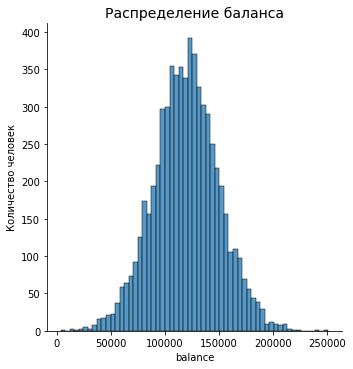

In [13]:
sns.displot(bank_data, x='balance')
plt.title('Распределение баланса', fontsize=14)
plt.ylabel('Количество человек')
plt.show()

Распределение похоже на нормальное. Также можно предположить, что у некоторых клиентов нет дебетового счета, а только кредитная карта или другой продукт, - в таком случае также возможны нули в признаке balance.

In [14]:
bank_data = bank_data.fillna(0)

In [16]:
bank_data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
credit_card         0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

### Работа с типами данных

Столбцы 'city', 'gender' имеют тип данных object, это не очень удобно для анализа. Такие данные лучше при возможности категоризовать.

In [17]:
bank_data.memory_usage()

Index                 128
user_id             80000
score               80000
city                80000
gender              80000
age                 80000
objects             80000
balance             80000
products            80000
credit_card         80000
loyalty             80000
estimated_salary    80000
churn               80000
dtype: int64

In [18]:
bank_data['gender'] = bank_data['gender'].replace({'М': 0, 'Ж': 1})

In [19]:
bank_data.memory_usage(index=False)

user_id             80000
score               80000
city                80000
gender              80000
age                 80000
objects             80000
balance             80000
products            80000
credit_card         80000
loyalty             80000
estimated_salary    80000
churn               80000
dtype: int64

In [20]:
bank_data.head(10)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,1,42,2,0.00,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,1,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,1,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,1,39,1,0.00,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,1,43,2,"125,510.82",1,1,1,"79,084.10",0
5,15616748,645,Рыбинск,0,44,8,"113,755.78",2,1,0,"149,756.71",1
6,15635267,822,Ярославль,0,50,7,0.00,2,1,1,"10,062.80",0
7,15698884,376,Ростов Великий,1,29,4,"115,046.74",4,1,0,"119,346.88",1
8,15835101,501,Ярославль,0,44,4,"142,051.07",2,0,1,"74,940.50",0
9,15635125,684,Ярославль,0,27,2,"134,603.88",1,1,1,"71,725.73",0


In [21]:
bank_data['gender'].value_counts()

0    5457
1    4543
Name: gender, dtype: int64

Итак, в датасете 10 000 строк, пропущенные значения были обработаны, также изменены некоторые типы данных.

## Исследовательский анализ данных (EDA)

### Описательные статистики признаков

Исследуем описательные статистики данных.

In [24]:
bank_data.describe()

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"15,733,676.57",650.53,0.45,38.92,5.01,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"71,936.19",96.65,0.50,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,"15,608,437.00",350.00,0.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"15,671,264.25",584.00,0.00,32.00,3.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"15,733,474.00",652.00,0.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"15,795,969.75",718.00,1.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"15,858,426.00",850.00,1.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


Сделаем выводы по таблице:
   * Значения кредитного скоринга колеблются от 350 до 850 баллов (чем больше, тем лучше), среднее значение - 650. 
   *  Возраст клиентов - от 18 до 92 лет, в среднем - 39 лет. 
   *  У клиентов в собственности от 0 до 10 объектов недвижимости, в среднем 5. 
   *  Баланс на дебетовом счете варьируется от 3 769 до 250 898 руб. 
   *  Клиенты пользуются от 1 до 4 банковскими продуктами, в среднем 1,53.
   *  Кредитная карта есть у 71% банковских клиентов.
   *  Заработная плата клиентов в среднем составляет 100 090 руб. 
   *  Доля оттока составляет 20%.
   *  По гендерному признаку 55% клиентов банка - мужчины, 45% - женщины.

In [25]:
bank_data = bank_data.drop(['user_id'], axis = 1)

### Гистограммы распределения признаков и столбчатые диаграммы признаков банковских клиентов

Посмотрим на распределения признаков. 

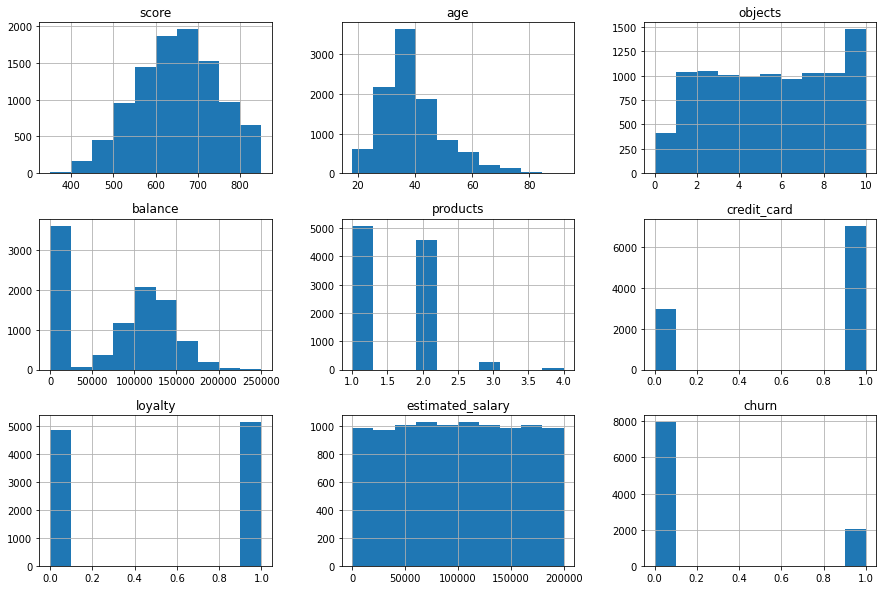

In [26]:
bank_data.drop(['gender'], axis = 1).hist(figsize=(15,10))
plt.show()

Сделаем выводы:
 * Кредитный скоринг распределен близко к нормальному, в основном клиенты имеют среднее значение 650-700 баллов.
 * Количество клиентов с 1-2 продуктами намного больше, чем с 3-4 продуктами.
 * Большая часть клиентов имеет кредитные карты.
 * По лояльности клиенты разделены примерно поровну.
 * В датасете равномерно представлены клиенты с разным уровнем зарплат.

### Размер групп клиентов в зависимости от количества продуктов

Исследуем размер групп клиентов в зависимости от количества продуктов.

In [27]:
bank_data_counts = bank_data['products'].value_counts().to_frame().reset_index()
bank_data_counts

,index,products
0,1,5084
1,2,4590
2,3,266
3,4,60


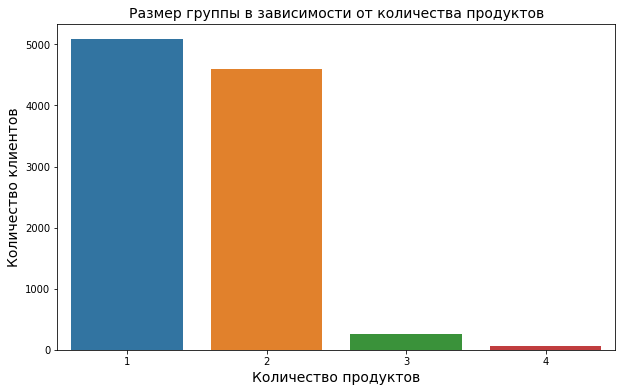

In [28]:
plt.figure(figsize=(10, 6))
plt.grid = True

sns.barplot(data=bank_data_counts, x='index', y='products')

plt.title('Размер группы в зависимости от количества продуктов',fontsize=14)

plt.xlabel('Количество продуктов', fontsize=14)
plt.ylabel('Количество клиентов',fontsize=14)
plt.show()

Количество пользователей 1 и 2 продуктов банка – 5084 и 4590 соответственно.
Больше, чем в 10 раз ниже количество пользователей 3 и 4 продуктов – 266 и 60.

### Исследование групп клиентов с 3-4 продуктами

Рассмотрим подробнее группы клиентов с 3-4 продуктами.

In [29]:
bank_data.query('products == 3').describe().T

,count,mean,std,min,25%,50%,75%,max
score,266.00,648.11,95.19,358.00,586.00,650.00,711.00,850.00
gender,266.00,0.56,0.50,0.00,0.00,1.00,1.00,1.00
age,266.00,43.20,10.42,21.00,36.00,42.00,50.00,77.00
objects,266.00,5.00,2.88,0.00,3.00,5.00,8.00,10.00
balance,266.00,"75,458.33","62,924.62",0.00,0.00,"95,973.93","127,522.35","250,898.09"
products,266.00,3.00,0.00,3.00,3.00,3.00,3.00,3.00
credit_card,266.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,266.00,0.42,0.50,0.00,0.00,0.00,1.00,1.00
estimated_salary,266.00,"104,318.13","55,464.28","3,440.47","64,344.80","101,046.89","152,230.20","199,357.24"
churn,266.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00


Клиенты с 3-мя продуктами примерно поровну разделены по полу, средний возраст - 43 года, среднее кол-во объектов недвижимости - 5, средний остаток на счете - 75 тыс. руб., у 71% есть кредитная карта, лояльность в среднем составляет 42%. Уровень оттока - 83% (очень высокое значение).

In [30]:
bank_data.query('products == 4').describe().T

,count,mean,std,min,25%,50%,75%,max
score,60.00,653.58,101.27,376.00,595.00,643.00,708.00,850.00
gender,60.00,0.63,0.49,0.00,0.00,1.00,1.00,1.00
age,60.00,45.68,8.62,29.00,40.00,45.00,50.25,68.00
objects,60.00,5.30,2.95,1.00,2.75,5.00,8.00,10.00
balance,60.00,"93,733.14","57,507.38",0.00,"65,787.32","116,808.20","131,589.51","195,238.29"
products,60.00,4.00,0.00,4.00,4.00,4.00,4.00,4.00
credit_card,60.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
loyalty,60.00,0.48,0.50,0.00,0.00,0.00,1.00,1.00
estimated_salary,60.00,"104,763.72","57,526.49","5,669.31","62,033.39","112,163.11","139,371.95","198,874.52"
churn,60.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


Клиенты с 4-мя продуктами все уходят, отток в среднем 100%. Лояльонсть 48%, средний возраст - 45 лет, средний кредитный скоринг 653, среднее кол-во объектов недвижимости 5.3, баланс - около 93 тыс. руб., средняя зарплата - около 104 тыс. руб.

Возможно, 3-ий и 4-й продукты запущены как бета-версия, и только тестируются, поэтому число клиентов еще не велико. Продукты  еще не доработаны, и клиентам не нравятся (о чем свидетельстует отток).

In [31]:
bank_data.groupby('products').agg('mean')[2:]

,score,gender,age,objects,balance,credit_card,loyalty,estimated_salary,churn
products,,,,,,,,,
3,648.11,0.56,43.20,5.00,"75,458.33",0.71,0.42,"104,318.13",0.83
4,653.58,0.63,45.68,5.30,"93,733.14",0.68,0.48,"104,763.72",1.00


Скоринг выше в группе с 4 продуктами, там же выше остатки на балансе, заработная плата, лояльность, возраст, количество объектов недвижимости. Доля клиентов с кредитными картыми выше в группе с 3мя продуктами. Отток в группе с 4-мя продуктами 100%-й.

### География пользователей

Рассмотрим географию пользователей, города проживания.

In [32]:
bank_data_city = bank_data['city'].value_counts().to_frame()
bank_data_city

,city
Ярославль,5014
Ростов Великий,2509
Рыбинск,2477


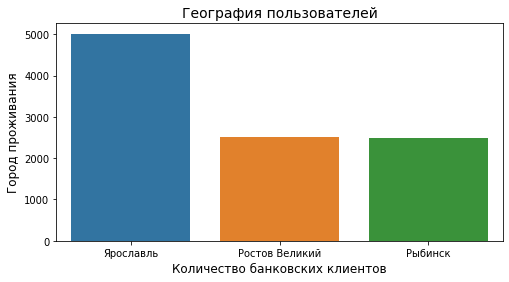

In [33]:
plt.figure(figsize=(8, 4))
plt.grid = True

sns.barplot(data=bank_data_city.reset_index(), x='index', y='city')

plt.title('География пользователей',fontsize=14)

plt.xlabel('Количество банковских клиентов', fontsize=12)
plt.ylabel('Город проживания',fontsize=12)
plt.show()

In [34]:
bank_data.pivot_table(index = 'city', columns = 'products', values = 'estimated_salary', aggfunc = 'count')

products,1,2,3,4
city,,,,
Ростов Великий,1349,1040,96,24
Рыбинск,1221,1183,66,7
Ярославль,2514,2367,104,29


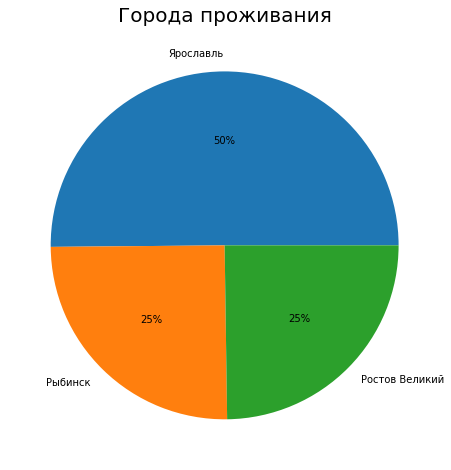

In [35]:
plt.figure(figsize=(8, 8))
labels = ['Ярославль', 'Рыбинск', 'Ростов Великий']

plt.pie(bank_data['city'].value_counts().to_frame().reset_index()['city'], 
        autopct='%.0f%%',
       labels=labels)

plt.title('Города проживания',  fontsize = 20)
plt.show()

Выводы:
* Больше всего клиентов проживает в г. Ярославле (столице региона) – 5014 чел. (50%),
* В г. Ростов Великий проживает 2509 человек (25%),
* В г. Рыбинск живет 2477 человек (25%).

### Корреляционная матрица

Посмотрим на корреляцию между признаками.

In [36]:
corr_matrix = bank_data.corr()
corr_matrix

,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
score,1.00,0.00,-0.00,0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
gender,0.00,1.00,0.03,-0.01,-0.01,0.02,-0.01,-0.02,0.01,0.11
age,-0.00,0.03,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
objects,0.00,-0.01,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01
balance,0.01,-0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
products,0.01,0.02,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
credit_card,-0.01,-0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01
loyalty,0.03,-0.02,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
estimated_salary,-0.00,0.01,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01
churn,-0.03,0.11,0.29,-0.01,0.12,-0.05,-0.01,-0.16,0.01,1.00


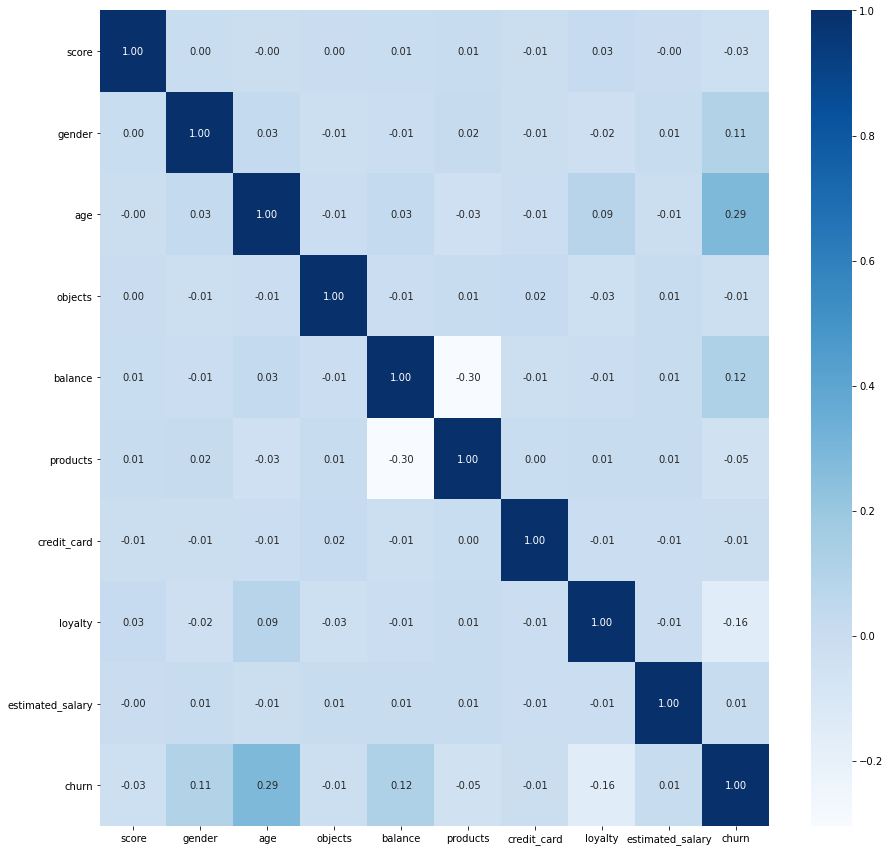

In [37]:
plt.figure(figsize=(15,15))
sns.heatmap(bank_data.corr(), annot=True, cmap="Blues", fmt='.2f')
plt.show()

На основании корреляционной матрицы сделаем вывод, что не зафиксировано признаков, которые существленно влияют друг на друга. Странно, что размер баланса на дебетовой карте (накопления) не зависят от уровня заработной платы.

Чтобы быть точнее при интерпретации коэффициента корреляции, можно использовать таблицу Чеддока:

|Значение|Интерпретация типа|
|:-----|:-----|
|от 0 до 0,3|очень слабая|
|от 0,3 до 0,5|слабая|
|от 0, 5 до 0,7|средняя|
|от 0,7 до 0,9|высокая|
|от 0,9 до 1|очень высокая|

На тепловой карте максимальное значение **0,3** (слабая связь: между количеством продуктов и состоянием баланса), **0,29** (слабая связь: - между характеристиками возраста и оттока). Остальные коэффициенты корреляции свидетельствуют об отсутствии связи или очень слабой корреляции.

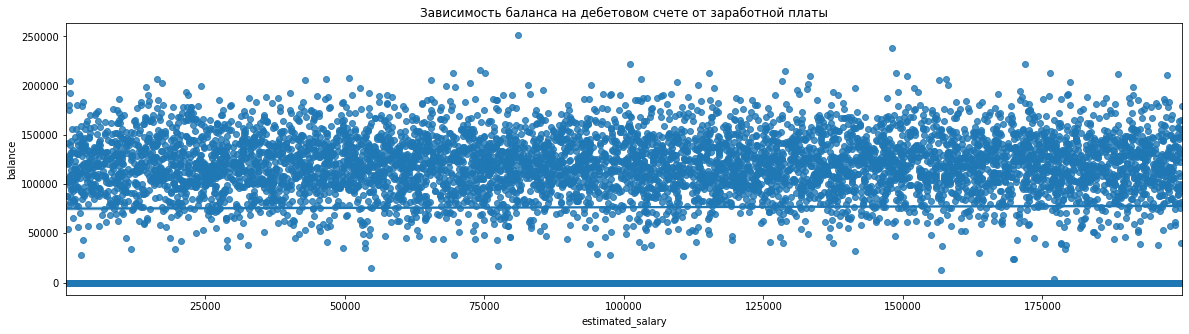

In [38]:
plt.figure(figsize=(20,5))
#plt.grid(True)
plt.title('Зависимость баланса на дебетовом счете от заработной платы')

sns.regplot(data=bank_data, y='balance', x='estimated_salary')
plt.show()

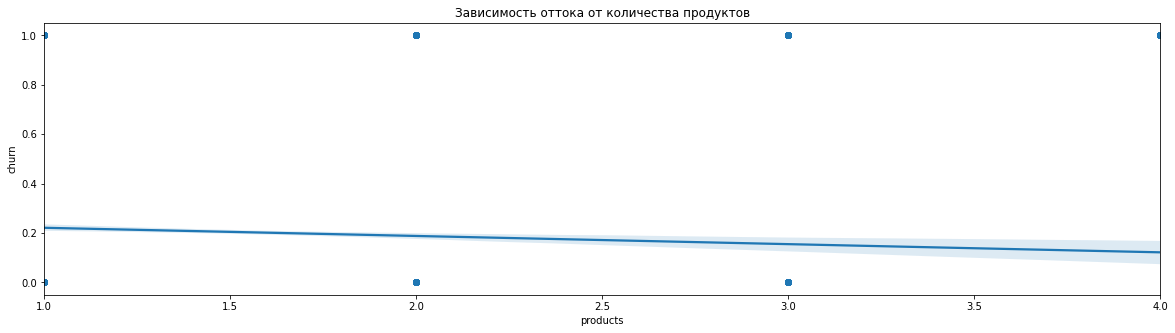

In [39]:
plt.figure(figsize=(20,5))
#plt.grid(True)
plt.title('Зависимость оттока от количества продуктов')

sns.regplot(data=bank_data, x='products', y='churn')
plt.show()

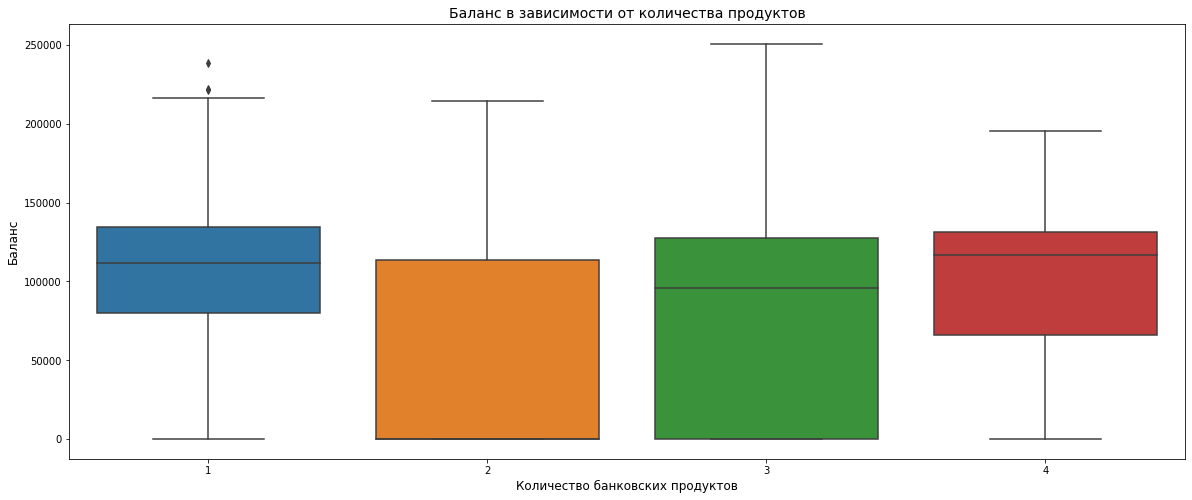

In [40]:
plt.figure(figsize=(20,8))
#plt.grid(True)
sns.boxplot(data=bank_data, x='products', y='balance')

plt.title('Баланс в зависимости от количества продуктов',fontsize=14)
plt.xlabel('Количество банковских продуктов', fontsize=12)
plt.ylabel('Баланс',fontsize=12)
plt.show()

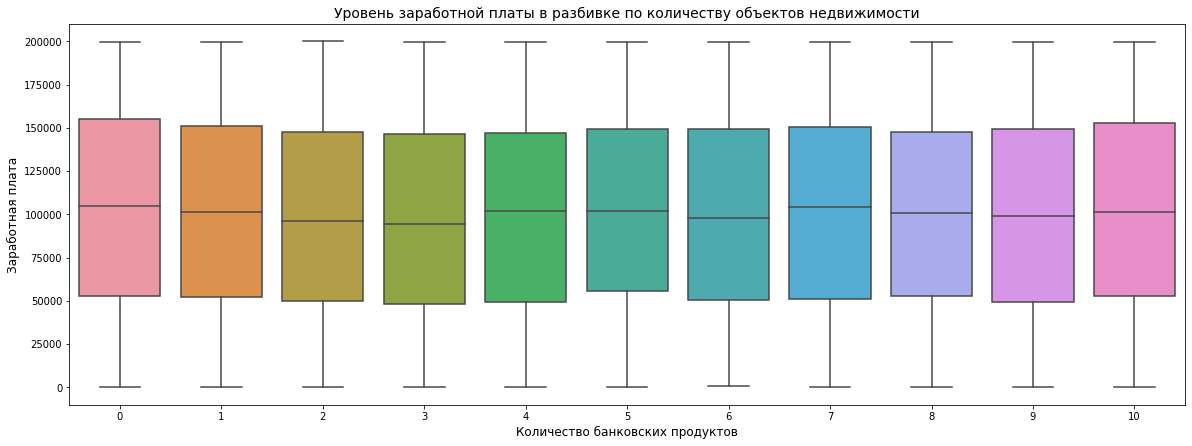

In [41]:
plt.figure(figsize=(20,7))
#plt.grid(True)
sns.boxplot(data=bank_data, x='objects', y='estimated_salary')
plt.title('Уровень заработной платы в разбивке по количеству объектов недвижимости',fontsize=14)
plt.xlabel('Количество банковских продуктов', fontsize=12)
plt.ylabel('Заработная плата',fontsize=12)
plt.show()

Построим график sns.pairplot() для некоторых отдельных признаков, которые хотелось бы рассмотреть вместе.

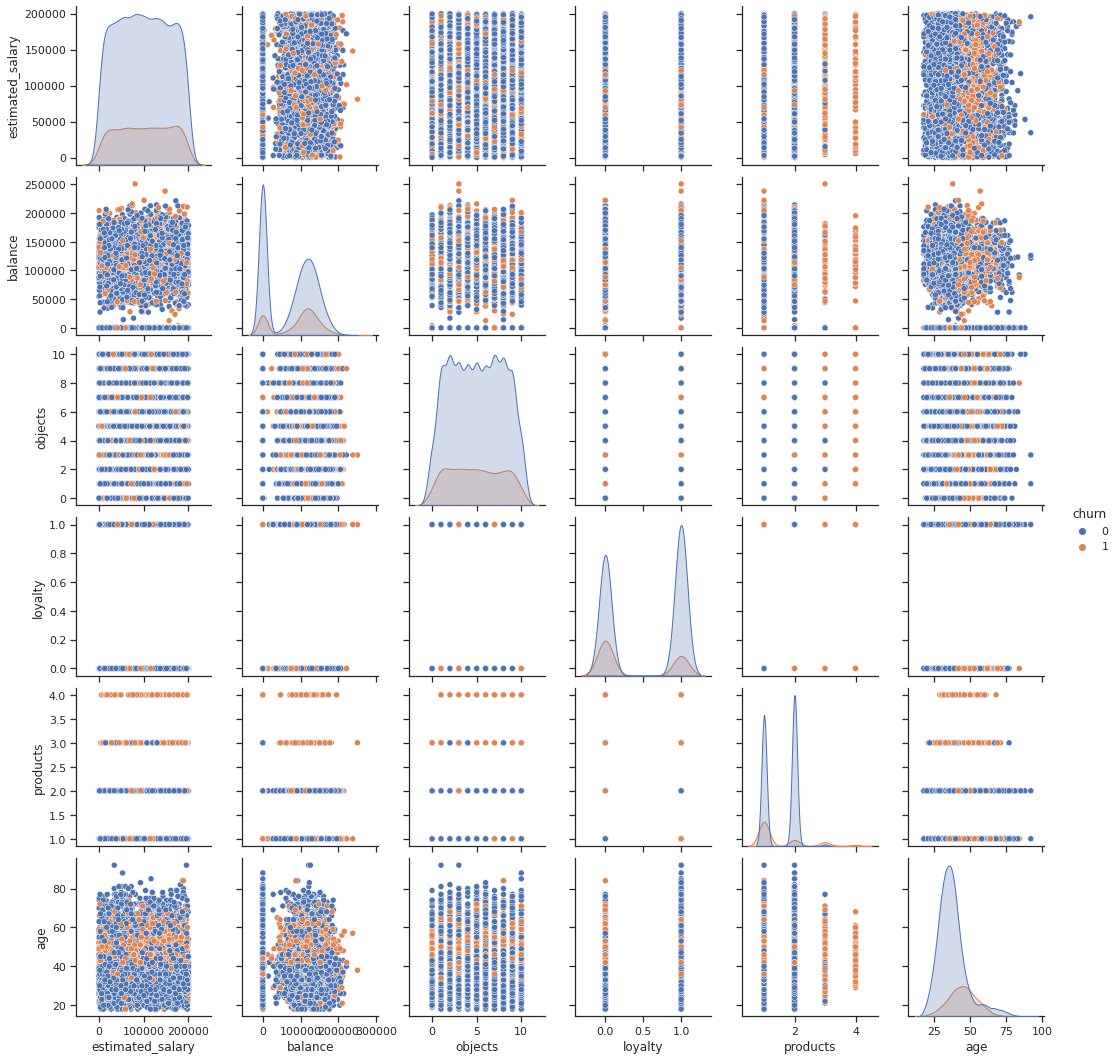

In [42]:
sns.set_theme(style="ticks")
sns.pairplot(bank_data[['estimated_salary', 'balance', 'objects', 'loyalty',  'products', 'churn', 'age' ]], hue = 'churn')
plt.show()

**Сделаем выводы:**

 * Кредитный скоринг распределен близко к нормальному, в основном клиенты имеют среднее значение 650-700 баллов.
 * Количество клиентов с 1-2 продуктами намного больше, чем с 3-4 продуктами.
 * Большая часть клиентов имеет кредитные карты.
 * По лояльности клиенты разделены примерно поровну.
 * В датасете равномерно представлены клиенты с разным уровнем зарплат.

## Сегментирование банковских клиентов

### Сводные таблицы

Построим сводные таблицы для разделения банковских клиентов на группы в зависимости от количества используемых продуктов.

In [43]:
bank_data.groupby('products').agg('mean')

,score,gender,age,objects,balance,credit_card,loyalty,estimated_salary,churn
products,,,,,,,,,
1,649.12,0.45,39.67,4.97,"98,551.87",0.70,0.50,"99,487.26",0.28
2,652.19,0.45,37.75,5.05,"51,879.15",0.71,0.53,"100,452.01",0.08
3,648.11,0.56,43.20,5.00,"75,458.33",0.71,0.42,"104,318.13",0.83
4,653.58,0.63,45.68,5.30,"93,733.14",0.68,0.48,"104,763.72",1.00


In [44]:
bank_data_grouped = bank_data.groupby('products').agg('median').reset_index()
bank_data_grouped

,products,score,gender,age,objects,balance,credit_card,loyalty,estimated_salary,churn
0,1,651,0,38,5,"111,886.04",1,1,"99,226.83",0
1,2,653,0,36,5,0.00,1,1,"100,738.85",0
2,3,650,1,42,5,"95,973.93",1,0,"101,046.89",1
3,4,643,1,45,5,"116,808.20",1,0,"112,163.11",1


Разделение на группы по количеству продуктов показало, что:
* клиенты с 1-2 банковскими продуктами не склонны к оттоку,
* клиенты с множественными продуктами (3-4) склонны к высокому уровню оттока, значит, им что-то не нравится в условиях дополнительных продуктов (это могут быть какие-либо инвестиционные продукты, вклады и др.).

Построим графики признаков в зависимости от количества используемых банковских продуктов. 

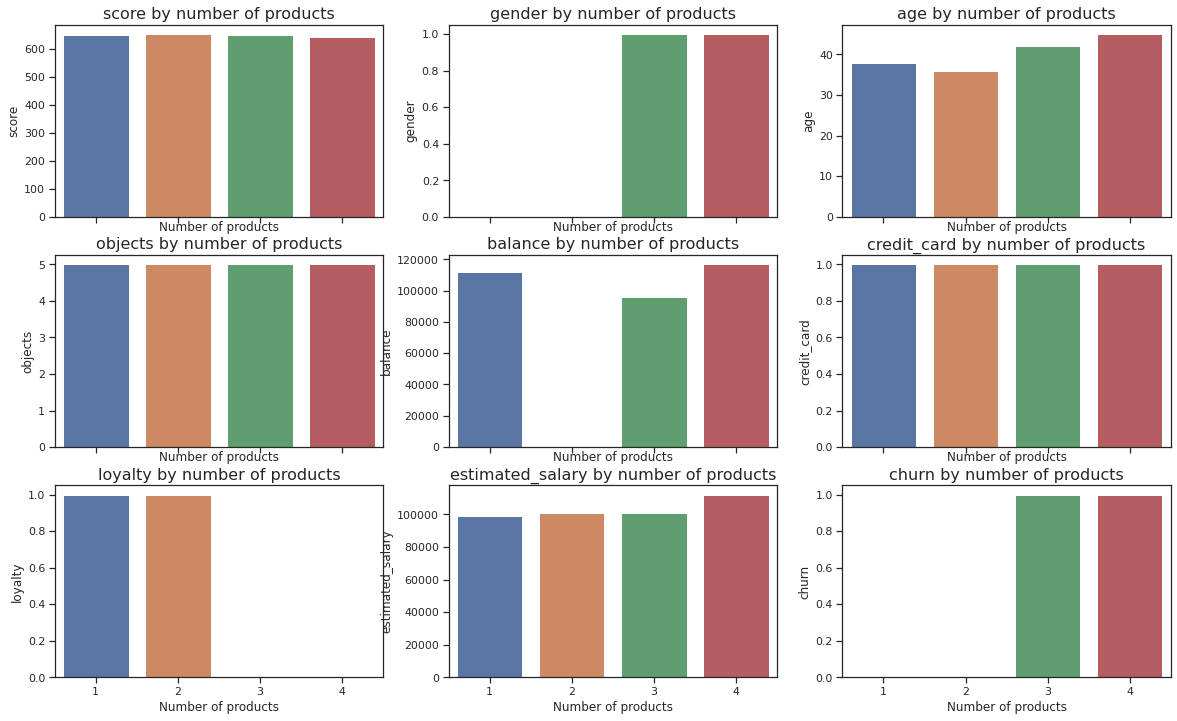

In [45]:
#define plotting region (number of rows, number of columns)
fig, axes = plt.subplots(3, 3, figsize=(20,12), sharex=True)

#create plot in each subplot

for index, column in enumerate(bank_data_grouped.columns[1:]):
    row = index // 3
    col = index % 3
    
    ax = sns.barplot(data=bank_data_grouped, x='products', y=column, ax=axes[row, col])
    
    ax.set_title(column + ' by number of products', fontsize=16)
    ax.set_xlabel('Number of products', fontsize=12)
plt.show()

Из графиков можно сделать вывод, что:
* основные отличия между группами состоят в том, что медианная лояльность клиентов с 1-2 продуктами высокая, а с 3-4 продуктами - низкая; также к оттоку склонны клиенты с большим количеством продуктов. Данные также показали, что 1-2 продуктами пользуются в основном женщины, а 3-4 продуктами - мужчины.
* группы клиентов по потреблению имеют похожие характеристики по кредитному скорингу, балансу, количеству объектов недвижимости.
* заработная плата клиентов с 4-ми продуктами выше, чем у других групп.    

### Распределения признаков в зависимости от количества используемых банковских продуктов

Посмтрим гистрограммы распределения в зависимости от количества банковских продуктов.

In [46]:
def plot_dist(data, column):
    plt.figure(figsize=(15,5))
    ax = sns.displot(data=data,
                     x=column, 
                     kind="kde", 
                     height=6,
                     aspect=2,
                     hue="products",
                     #multiple="stack",
                     fill = True
                    )

    #ax.set_xticklabels(rotation = 30)
    plt.title(f"Distribution histogram of {column}")
   
    plt.show()

<Figure size 1080x360 with 0 Axes>

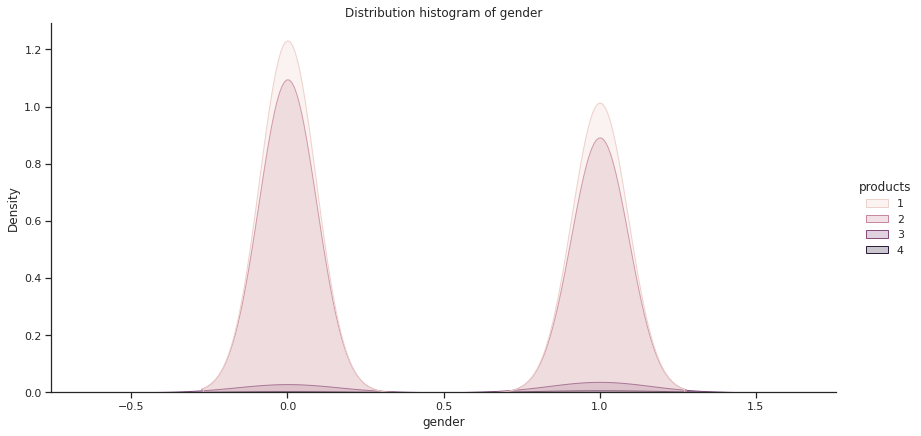

<Figure size 1080x360 with 0 Axes>

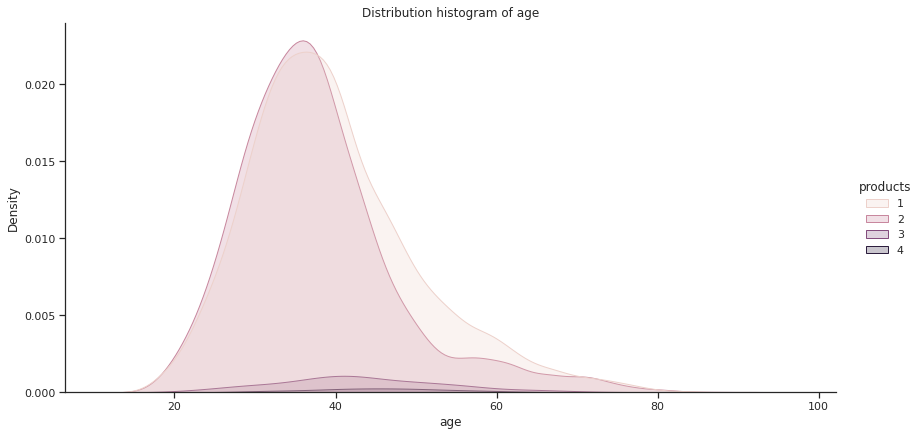

<Figure size 1080x360 with 0 Axes>

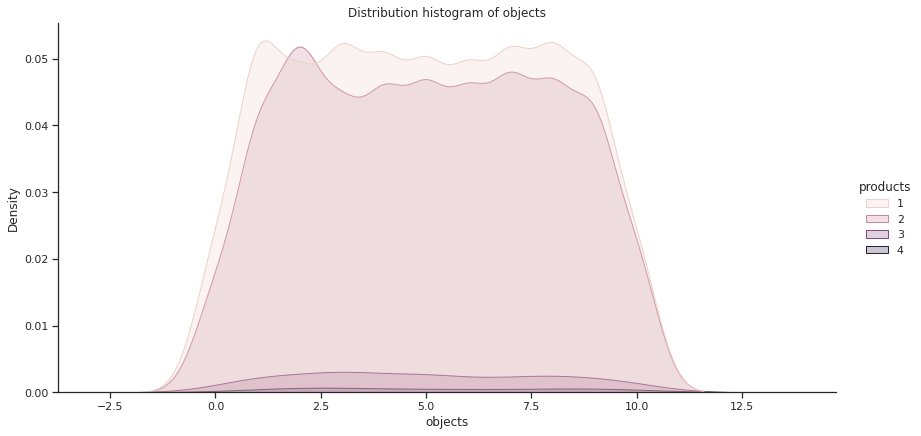

<Figure size 1080x360 with 0 Axes>

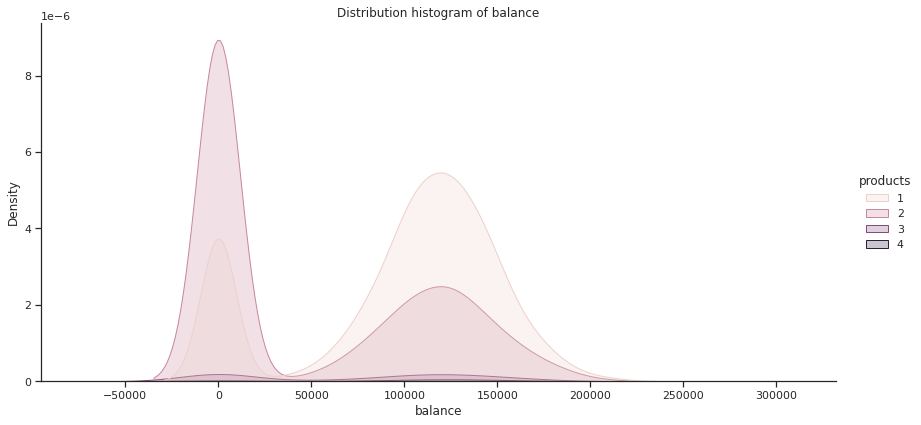

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1080x360 with 0 Axes>

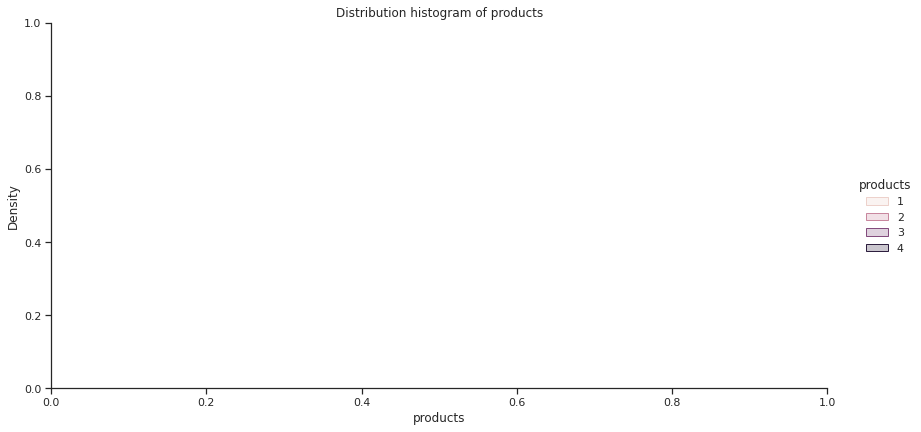

<Figure size 1080x360 with 0 Axes>

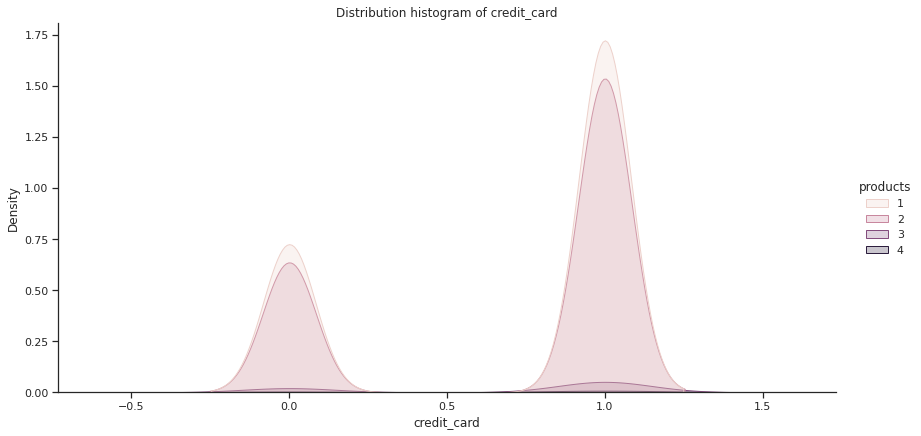

<Figure size 1080x360 with 0 Axes>

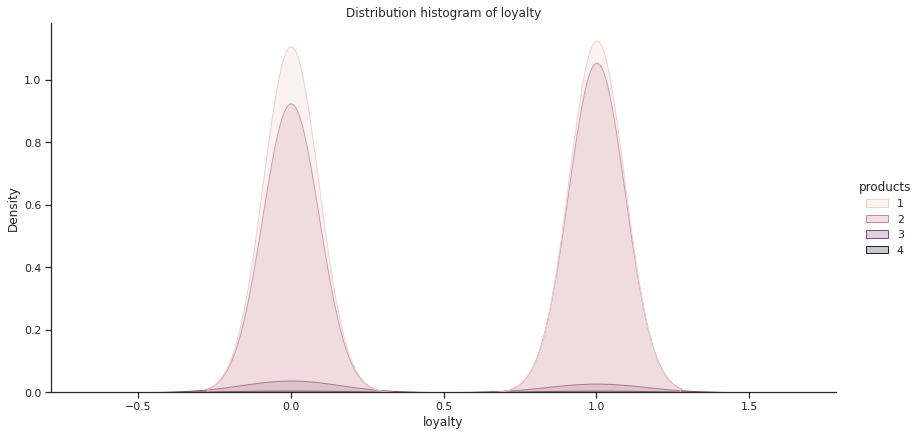

<Figure size 1080x360 with 0 Axes>

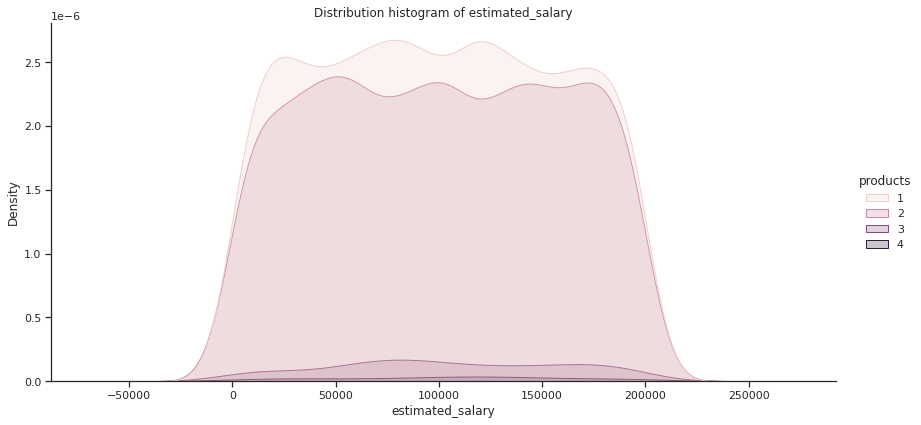

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1080x360 with 0 Axes>

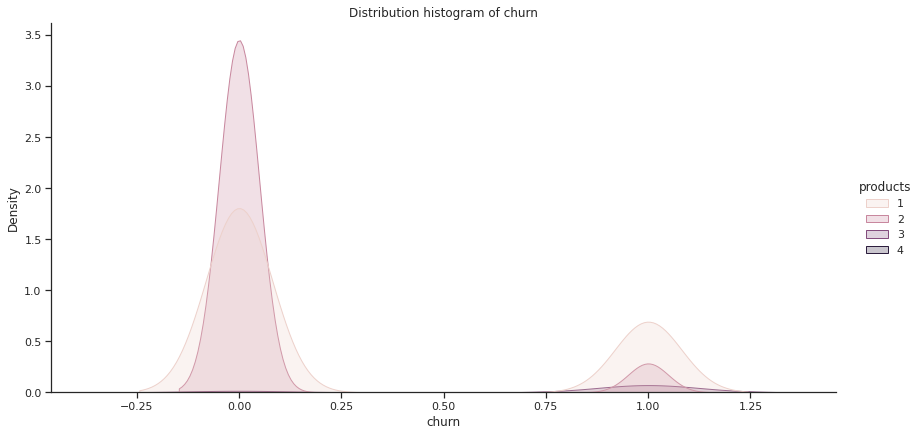

In [47]:
for column in bank_data.columns[2:]:
    plot_dist(bank_data, column)    

Видно, что лояльность и отток отличаются у 1-2 групп и 3-4 групп.

Были выделены следующие сегменты:

**Первый и второй сегмент:**
 * Количество банковских продуктов: 1-2,
 * Пол – женский,
 * Отток – 0,
 * Лояльность – 1.

**Третий и четвертый сегмент:**
 * Количество банковских продуктов: 3-4,
 * Пол – мужской,
 * Отток – 1,
 * Лояльность – 0.


### Кластеризация

Используем алгоритим кластеризации для сегментации другим способом.

In [48]:
bank_data_cluster = bank_data.drop(['city'], axis = 1).copy()
bank_data_cluster

,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,619,1,42,2,0.00,1,1,1,"101,348.88",1
1,608,1,41,1,"83,807.86",1,0,1,"112,542.58",0
2,502,1,42,8,"159,660.80",3,1,0,"113,931.57",1
3,699,1,39,1,0.00,2,0,0,"93,826.63",0
4,850,1,43,2,"125,510.82",1,1,1,"79,084.10",0
...,...,...,...,...,...,...,...,...,...,...
9995,771,0,39,5,0.00,2,1,0,"96,270.64",0
9996,516,0,35,10,"57,369.61",1,1,1,"101,699.77",0
9997,709,1,36,7,0.00,1,0,1,"42,085.58",1
9998,772,0,42,3,"75,075.31",2,1,0,"92,888.52",1


In [49]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(bank_data_cluster)

In [50]:
linked = linkage(X_sc, method = 'ward') 

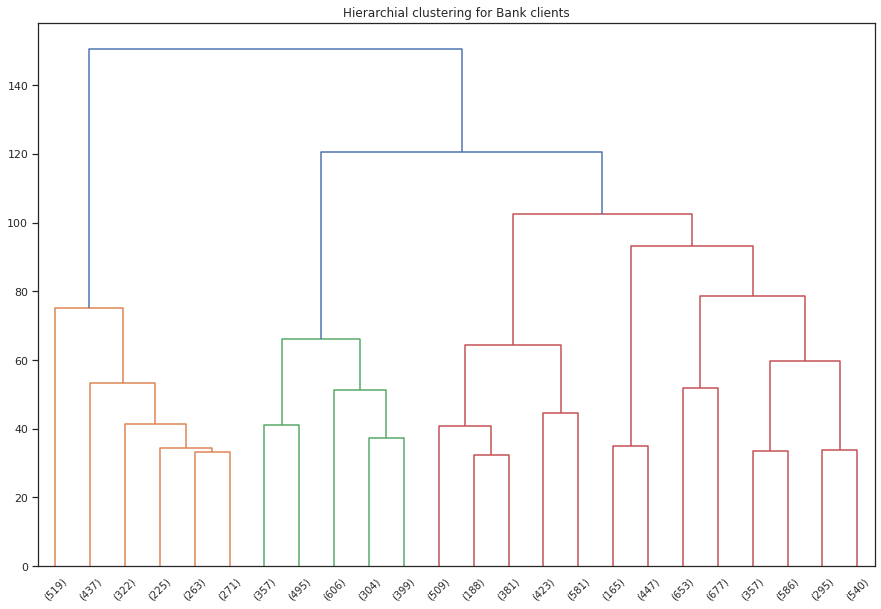

In [51]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', truncate_mode = 'lastp', p = 24, leaf_rotation = 45)
plt.title('Hierarchial clustering for Bank clients')
plt.show()

Из дендрограммы видно, сколько кластеров можно использовать. Чем больше уровень детализации, тем больше кластеров.

Дендрограмма показывает, что оптимальное значение кластеров - 3 (они подсвечены синим цветом).

Для определения оптимального количества кластеров можно также использовать метод локтя:

In [52]:
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X_sc)

In [53]:
gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(X_sc)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X_scaled)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X_sc)))
    print("-"*100)
    gm_bic.append(-gm.bic(X_sc))
    gm_score.append(gm.score(X_sc))

BIC for number of cluster(s) 2: 3982116199.465027
Log-likelihood score for number of cluster(s) 2: -7.083965691417483
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: 5660752924.763151
Log-likelihood score for number of cluster(s) 3: -1.6667175647480708
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: 5660758244.381139
Log-likelihood score for number of cluster(s) 4: 0.7022393647377446
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: 9003608465.91466
Log-likelihood score for number of cluster(s) 5: 3.431339422089336
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: 9003609073.797125
Log-likelihood score for number of cluster(s) 6: 4.999240936147018
--------

/tmp/ipykernel_42/2928884842.py:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')


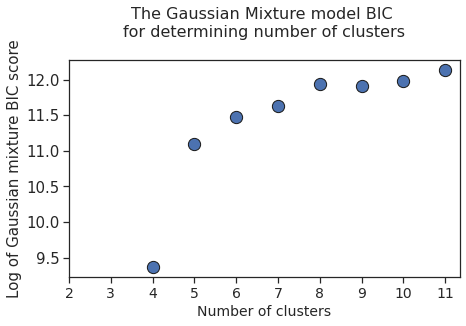

In [54]:
plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
#plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Резкий скачок до 7-8 кластеров и говорит нам о максимальном логичном количестве в наших данных.

In [55]:
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)

In [56]:
data_cluster = bank_data.copy()

In [57]:
data_cluster['cluster'] = labels
data_cluster.head()

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,cluster
0,619,Ярославль,1,42,2,0.00,1,1,1,"101,348.88",1,0
1,608,Рыбинск,1,41,1,"83,807.86",1,0,1,"112,542.58",0,2
2,502,Ярославль,1,42,8,"159,660.80",3,1,0,"113,931.57",1,0
3,699,Ярославль,1,39,1,0.00,2,0,0,"93,826.63",0,2
4,850,Рыбинск,1,43,2,"125,510.82",1,1,1,"79,084.10",0,3


In [58]:
clusters = data_cluster.groupby(['cluster']).mean()
clusters.T

cluster,0,1,2,3
score,645.28,651.08,652.39,652.04
gender,0.56,0.44,0.43,0.41
age,44.94,37.48,37.47,37.30
objects,4.93,5.15,4.91,5.03
balance,"92,149.00","4,437.79","74,143.01","122,087.97"
products,1.46,1.85,1.54,1.33
credit_card,0.70,1.00,0.00,1.00
loyalty,0.36,0.55,0.55,0.56
estimated_salary,"101,300.22","98,159.12","100,288.76","100,632.82"
churn,1.00,0.01,0.00,0.00


Составим портреты потребителей банковских продуктов:

|Сегмент (кластер)|Описание сегмента|
|:-----|:-----|
|0| **"Ушедшие"**. В этом сегменте - клиенты, покинувшие банк (отток - 100%). Средний балл - 645, средний возраст - 44,9. Пользуются в среднем 1-2 продуктами. Лояльность 36%, остатки на счетах не низкие. Самая низкая лояльность|
|1|**Обладатели низкого баланса**. Средний баланс - 4437 руб. У 100% есть кредитная карта. Возможно, предпочитают не иметь дебетовый счет. Среднее количество банковских продуктов - 1.85 - самое высокое значение (возможно, любят вклады или инвестиции). Лояльность 55%. Низкий отток - 1%.|
|2|**'Противники кредитов'**. У 100% клиентов здесь нет кредитных карт. Кол-во продуктов - 1.54. Лояльность 55%. Низкий отток - 0%. Средний возраст - 37 лет.  |
|3|**Любители кредитных карт**. У всех этих клиентов есть кредитные карты, при этом остатки на счетах - выше среднего. Они не склонны к оттоку. Лояльность выше других сегментов - 56%. Самая высокая заработная плата (100 600 р.). Среднее кол-во продуктов - 1.33. Пользуются и кредитными, и дебетовыми картами. Средний возраст - 37 лет. В сегменте 41% мужчин и 39% женщин.|

### Географическая сегментация с помощью кластеризации

Построим сегментацию по географическому признаку с использованием кластеризации. Для этого введем dummy-переменные из столбца city:

In [59]:
geo_data_cluster = bank_data.copy()
geo_data_cluster = pd.get_dummies(bank_data)

In [60]:
geo_data_cluster.head()

,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,619,1,42,2,0.00,1,1,1,"101,348.88",1,0,0,1
1,608,1,41,1,"83,807.86",1,0,1,"112,542.58",0,0,1,0
2,502,1,42,8,"159,660.80",3,1,0,"113,931.57",1,0,0,1
3,699,1,39,1,0.00,2,0,0,"93,826.63",0,0,0,1
4,850,1,43,2,"125,510.82",1,1,1,"79,084.10",0,0,1,0


In [61]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(geo_data_cluster)

In [62]:
linked = linkage(X_sc, method = 'ward') 

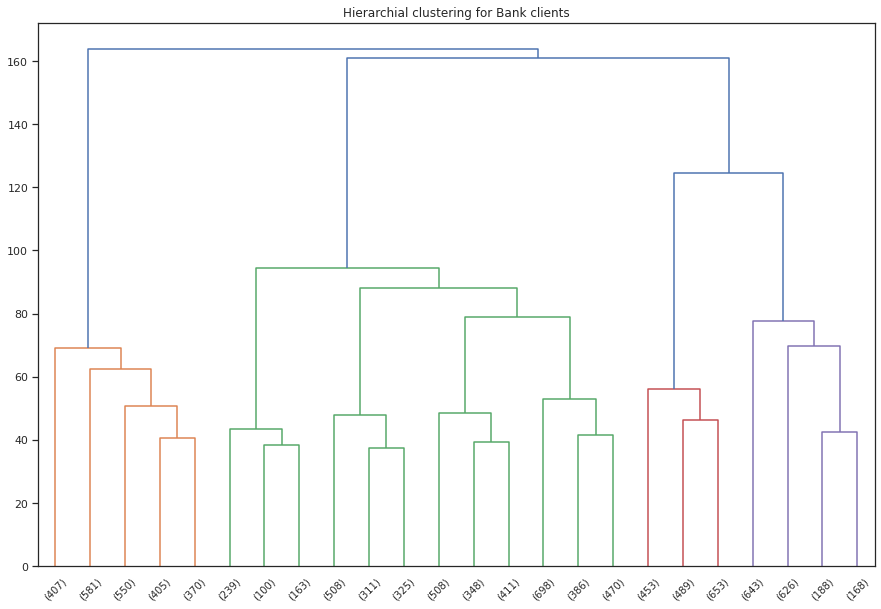

In [63]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', truncate_mode = 'lastp', p = 24, leaf_rotation = 45)
plt.title('Hierarchial clustering for Bank clients')
plt.show()

Согласно дендрограмме, нужно построить 4 кластера (темно-синий цвет). Проверим еще с помощью метода локтя.

In [64]:
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X_sc)

In [65]:
gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(X_sc)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X_scaled)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X_sc)))
    print("-"*100)
    gm_bic.append(-gm.bic(X_sc))
    gm_score.append(gm.score(X_sc))

BIC for number of cluster(s) 2: 8407290528.30533
Log-likelihood score for number of cluster(s) 2: -0.5909536032042539
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: 12695761297.91916
Log-likelihood score for number of cluster(s) 3: 3.1032612949658014
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: 14416125395.77505
Log-likelihood score for number of cluster(s) 4: 7.147279828423184
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: 14416131506.30701
Log-likelihood score for number of cluster(s) 5: 8.5736925067377
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: 15913943923.25118
Log-likelihood score for number of cluster(s) 6: 10.6377393030414
------------

/tmp/ipykernel_42/2928884842.py:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')


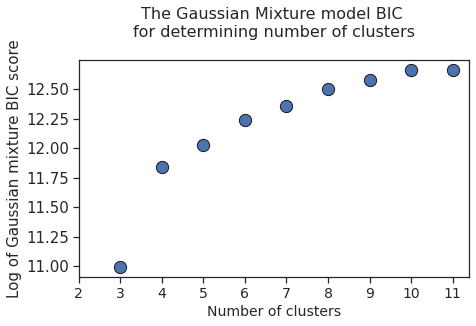

In [66]:
plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
#plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [67]:
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)

In [68]:
data_cluster = bank_data.copy()

In [69]:
geo_data_cluster['cluster'] = labels
geo_data_cluster.head()

,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,cluster
0,619,1,42,2,0.00,1,1,1,"101,348.88",1,0,0,1,2
1,608,1,41,1,"83,807.86",1,0,1,"112,542.58",0,0,1,0,3
2,502,1,42,8,"159,660.80",3,1,0,"113,931.57",1,0,0,1,1
3,699,1,39,1,0.00,2,0,0,"93,826.63",0,0,0,1,2
4,850,1,43,2,"125,510.82",1,1,1,"79,084.10",0,0,1,0,3


In [70]:
clusters = geo_data_cluster.groupby(['cluster']).mean()
clusters.T

cluster,0,1,2,3
score,651.45,650.82,648.61,651.33
gender,0.48,0.44,0.47,0.44
age,39.77,38.45,38.57,38.89
objects,5.01,4.93,5.07,5.03
balance,"119,730.12","122,883.37","6,412.32","61,818.15"
products,1.52,1.21,1.82,1.54
credit_card,0.71,0.70,0.71,0.69
loyalty,0.50,0.51,0.52,0.53
estimated_salary,"101,113.44","100,529.13","99,322.19","99,440.57"
churn,0.32,0.16,0.16,0.17


|Сегмент (кластер)|Описание сегмента|
|:-----|:-----|
|0| **Жители Роcтова Великого**. В этом сегменте - клиенты, равномерно распределенные по полу, средний возраст - 39 лет, пользуются 1.52 продуктами. Отток 32%. Лояльность 50%. У 71% есть кредитные карты.|   
|1|**Жители Ярославля**. Отток 16%, лояльность 51%. У 70% есть кредитные карты. Высокие остатки по счету (122 тыс.руб.). Средний возраст - 38 лет.|  
|2|**Жители Ярославля с низким балансом**. Средний баланс - чуть больше 6 т.р. У 71% есть кредитные карты. Самое высокое разнообразие продуктов - 1.82. Средний возраст - 38 лет. Отток 16%. Лояльность 52%.|
|3|**Жители Рыбинска**. Все представители сегмента проживают в г. Рыбинск. Их средние характеристики: возраст - 38 лет, балл - 651, 5 объектов недвижимости, 1.54 продуктов. Меньше всех любят кредитные карты (69%). Самая высокая лояльность (53%). Отток 17%.|

### Кластеризация с категоризацией

Категоризуем переменные balance, objects, estimated_salary на основании описательных статистик.

In [71]:
balance_descibed = bank_data['balance'].describe()
balance_descibed

count    10,000.00
mean     76,485.89
std      62,397.41
min           0.00
25%           0.00
50%      97,198.54
75%     127,644.24
max     250,898.09
Name: balance, dtype: float64

In [72]:
balance_descibed[4:7]

25%         0.00
50%    97,198.54
75%   127,644.24
Name: balance, dtype: float64

In [73]:
def determine_balance(balance):
    if balance <= balance_descibed[4]: return 0
    elif balance_descibed[4] < balance <= balance_descibed[5]: return 1
    elif balance_descibed[5] < balance <= balance_descibed[6]: return 2
    else: return 3

Будем использовать следующие параметры:
* 0 - нулевой баланс,
* 1 - от 0 до 97,198.54 (средний баланс)
* 2 - от 97,198.54 до 127,644.24 (высокий баланс)
* 3 - выше 127,644.24 (очень высокий баланс)

In [74]:
bank_data['balance_group'] = bank_data['balance'].apply(determine_balance)

Создадим функции, чтобы аналогичным образом категоризовать остальные признаки:

In [75]:
def determine_feature(feature, feature_described):
    # категоризует признак на основе собранной статистики

    if feature <= feature_described[4]: return 0
    elif feature_described[4] < feature <= feature_described[5]: return 1
    elif feature_described[5] < feature <= feature_described[6]: return 2
    else: return 3

def apply_feature(feature):
    #собирает статистику для произвольной фичи, применяет категоризацию

    feature_descr = bank_data[feature].describe()
    
    return bank_data[feature].apply(determine_feature, feature_described=feature_descr)    

In [76]:
bank_data["object_group"] = apply_feature("objects")
bank_data["salary_group"] = apply_feature("estimated_salary")
bank_data["score_group"] = apply_feature("score")

In [77]:
bank_data.head()

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_group,object_group,salary_group,score_group
0,619,Ярославль,1,42,2,0.00,1,1,1,"101,348.88",1,0,0,2,1
1,608,Рыбинск,1,41,1,"83,807.86",1,0,1,"112,542.58",0,1,0,2,1
2,502,Ярославль,1,42,8,"159,660.80",3,1,0,"113,931.57",1,3,3,2,0
3,699,Ярославль,1,39,1,0.00,2,0,0,"93,826.63",0,0,0,1,2
4,850,Рыбинск,1,43,2,"125,510.82",1,1,1,"79,084.10",0,2,0,1,3


In [78]:
bank_data_cat = bank_data.drop(['estimated_salary', 'balance', 'objects', 'score', 'city'], axis = 1)

In [79]:
bank_data_cat.head()

,gender,age,products,credit_card,loyalty,churn,balance_group,object_group,salary_group,score_group
0,1,42,1,1,1,1,0,0,2,1
1,1,41,1,0,1,0,1,0,2,1
2,1,42,3,1,0,1,3,3,2,0
3,1,39,2,0,0,0,0,0,1,2
4,1,43,1,1,1,0,2,0,1,3


Далее проведем кластеризацию.

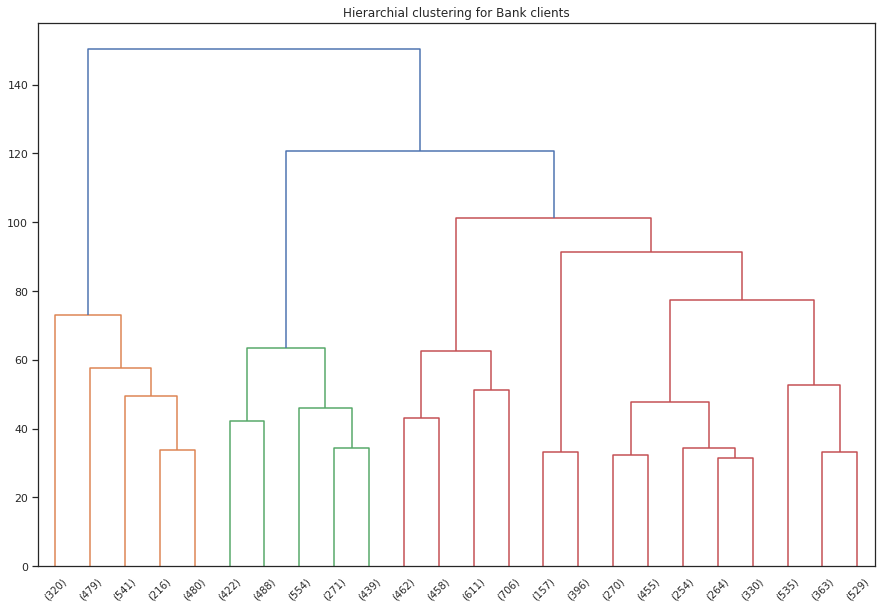

In [80]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(bank_data_cat)
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', truncate_mode = 'lastp', p = 24, leaf_rotation = 45)
plt.title('Hierarchial clustering for Bank clients')
plt.show()

In [81]:
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X_sc)

In [82]:
gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(X_sc)
    #print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X_scaled)))
    #print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X_sc)))
    #print("-"*100)
    gm_bic.append(-gm.bic(X_sc))
    gm_score.append(gm.score(X_sc))

/tmp/ipykernel_42/2928884842.py:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')


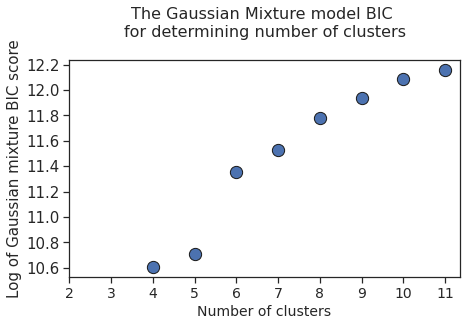

In [83]:
plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
#plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [84]:
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(X_sc)

In [85]:
bank_data_cat['cluster'] = labels

In [86]:
bank_data_cat.head()

,gender,age,products,credit_card,loyalty,churn,balance_group,object_group,salary_group,score_group,cluster
0,1,42,1,1,1,1,0,0,2,1,0
1,1,41,1,0,1,0,1,0,2,1,2
2,1,42,3,1,0,1,3,3,2,0,0
3,1,39,2,0,0,0,0,0,1,2,1
4,1,43,1,1,1,0,2,0,1,3,2


In [87]:
clusters = bank_data_cat.groupby(['cluster']).mean()
clusters.T

cluster,0,1,2
gender,0.56,0.44,0.42
age,44.94,37.33,37.46
products,1.45,1.86,1.30
credit_card,0.70,0.71,0.70
loyalty,0.36,0.54,0.56
churn,1.00,0.01,0.00
balance_group,1.68,0.12,2.27
object_group,1.32,1.38,1.34
salary_group,1.53,1.49,1.50
score_group,1.44,1.49,1.51


Здесь картина, похожая на первый вариант кластеризации:

|Сегмент (кластер)|Описание сегмента|
|:-----|:-----|
|0| **Ушедшие в отток**. Отток - 100%. Средний возраст 44 года.|   
|1|**С низким балансом**. Средний остаток на балансе - 0.12 - низкий. Большое разнообразие продуктов (1.86). Рекомендуется предлагать этим клиентам новшества, так как они любят тестировать новинки. Отток 1%, лояльность 54%|  
|2|**Постоянные клиенты**. Отток - 0%. Высокий уровень лояльности - 56%. Средний возраст - 37 лет. |

## Проверка статистических гипотез

Проверим следующие гипотезы:
 * доход клиентов, которые пользуются двумя продуктами, отличается от доходов клиентов, которые пользуются одним продуктом.
 * отток клиентов ниже у лояльных клиентов.
 * чем большим количеством продуктов пользуется клиент, тем ниже вероятность оттока.

Пороговое значение alpha зададим в 0.05.

Также в работе будут пояснения:
 * как формулировали нулевую и альтернативную гипотезы;
 * какой критерий использовали для проверки гипотез и почему.

### Проверка гипотезы №1

Гипотеза о равенстве средних двух генеральных совокупностей №1

Сформулируем гипотезы:

 * **H0:** средний доход клиентов с 1 и 2 продуктами не отличается (предположение о том, что связи нет)
 * **H1:** средний доход клиентов с 1 и 2 продуктами отличается

Далее будет проведена проверка гипотезы. Предварительно можно сказать, что сравниваемые выборки - независимые, поэтому будем использовать t-критерий Стьюдента.

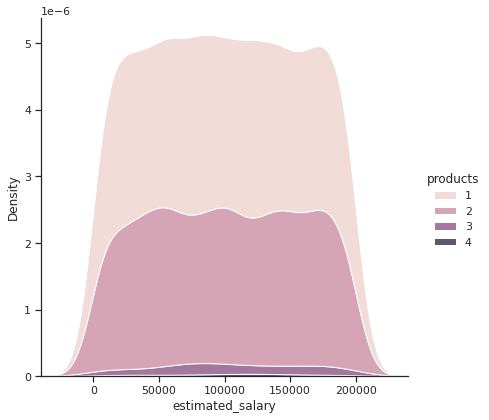

In [88]:
sns.displot(data=bank_data, x="estimated_salary", 
            #kde=True, 
            kind="kde",
            hue='products', 
            multiple="stack", 
            height=6, aspect=1)
plt.show()

In [89]:
q1 = bank_data['estimated_salary'].quantile(0.25)
q3 = bank_data['estimated_salary'].quantile(0.75)
iqr = q3 - q1  # iqr (Interquartile range (Межквартильный размах))
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

In [90]:
lower_limit

-96577.09624999999

In [91]:
upper_limit

296967.45375

In [92]:
bank_data['estimated_salary'].describe()

count    10,000.00
mean    100,090.24
std      57,510.49
min          11.58
25%      51,002.11
50%     100,193.91
75%     149,388.25
max     199,992.48
Name: estimated_salary, dtype: float64

В данных нет выбросов, поэтому используем t-критерий Стьюдента.

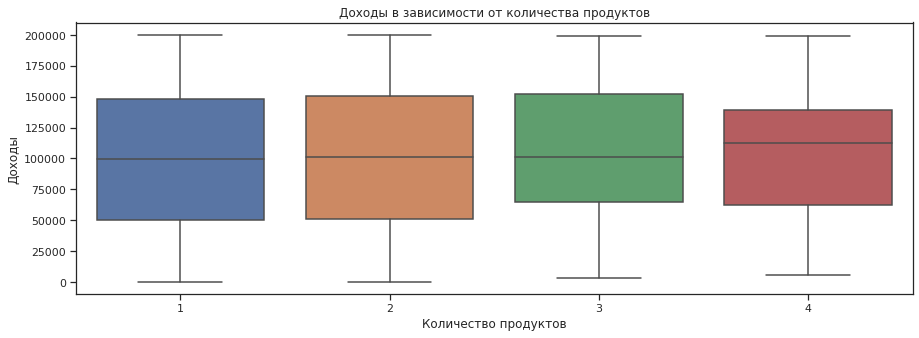

In [93]:
plt.figure(figsize=(15, 5))
plt.grid = True

sns.boxplot(data=bank_data, x='products', y='estimated_salary')

plt.title('Доходы в зависимости от количества продуктов',fontsize=12)
plt.ylabel('Доходы',fontsize=12)
plt.xlabel('Количество продуктов', fontsize=12)
plt.show()

В качестве дохода рассмотрим средний показатель estimated_salary по группам клиентов в зависимости от количества продуктов.

In [94]:
bank_data.groupby('products').agg({'estimated_salary': 'mean'})

,estimated_salary
products,
1,"99,487.26"
2,"100,452.01"
3,"104,318.13"
4,"104,763.72"


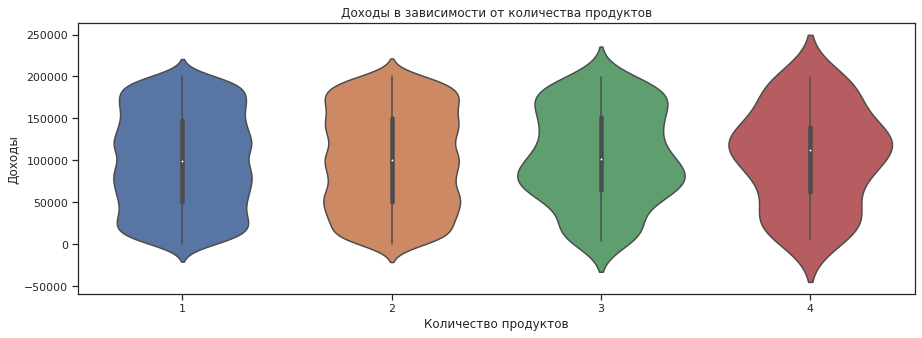

In [95]:
plt.figure(figsize=(15, 5))
plt.grid = True

sns.violinplot(data=bank_data, x='products', y='estimated_salary')

plt.title('Доходы в зависимости от количества продуктов',fontsize=12)
plt.ylabel('Доходы',fontsize=12)
plt.xlabel('Количество продуктов', fontsize=12)
plt.show()

Сравниваемые выборки - независимые, поэтому будем использовать t-критерий Стьюдента.

In [96]:
product_1 = bank_data.query('products == 1')['estimated_salary']

In [97]:
product_2 = bank_data.query('products == 2')['estimated_salary']

Проследили, что данные не содержат выбросов, поэтому применяем st.ttest_ind():

In [98]:
results = st.ttest_ind(product_1, product_2, equal_var=False)

In [99]:
results

Ttest_indResult(statistic=-0.8227874662645565, pvalue=0.4106493940071987)

In [100]:
alpha = 0.05

In [101]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


Для визулизации результата построим барплот с доходами двух групп.

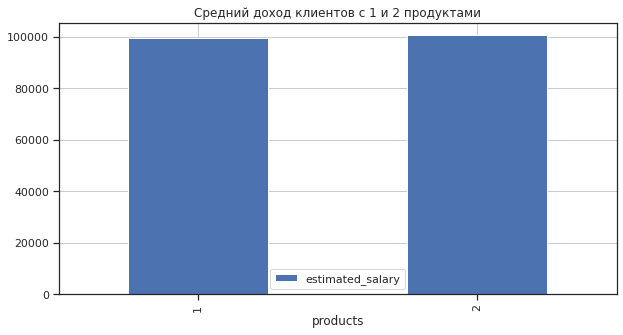

In [102]:
bank_data.groupby('products').agg({'estimated_salary': 'mean'})[:2].plot(kind='bar', figsize=(10, 5), grid=True)
plt.title("Средний доход клиентов с 1 и 2 продуктами")
plt.show()

**Вывод**: Мы не можем отвергнуть нулевую гипотезу. Между выборками нет существенных отличий. Средний доход клиентов с 1 и 2 продуктами примерно одинаков.

### Проверка гипотезы  №2

Чем большим количеством продуктов пользуется клиент, тем ниже вероятность оттока.

Проверим, хватает ли нам данных, чтобы проверять гипотезы для клиентов с 3-4 продуктами.

In [103]:
len(bank_data[(bank_data['products'] == 3) | (bank_data['products'] == 4)]['churn'])

326

Сформулируем гипотезы:

 * **H0:** отток клиентов с 1-м продуктом и более, чем 1-м продуктом не отличается (предположение о том, что связи нет)
 * **H1:** отток клиентов с 1-м продуктом и более, чем 1-м продуктом отличается

In [104]:
bank_data.pivot_table(index = 'products', values = 'churn', aggfunc = 'mean')

,churn
products,
1,0.28
2,0.08
3,0.83
4,1.00


In [105]:
bank_data['churn'].describe()

count   10,000.00
mean         0.20
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: churn, dtype: float64

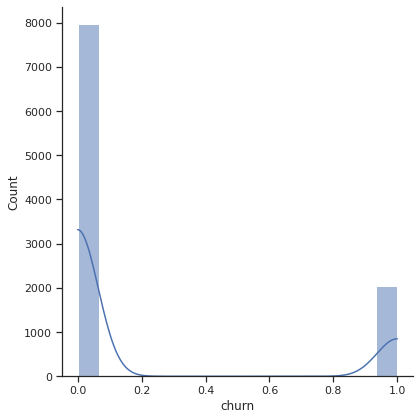

In [106]:
sns.displot(data=bank_data, x="churn", 
            kde=True, 
            height=6, aspect=1)
plt.show()

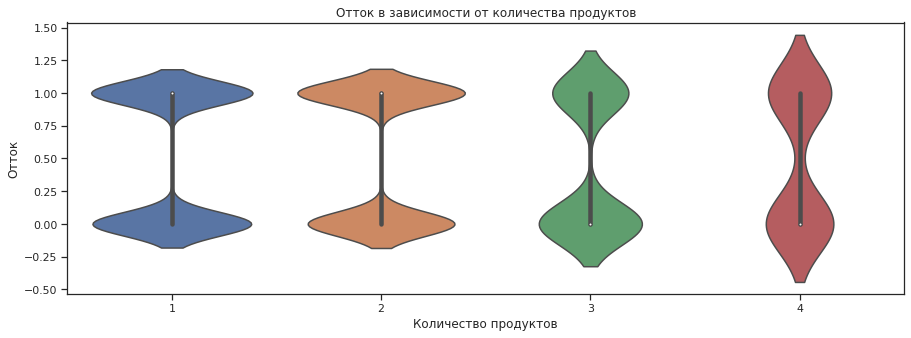

In [107]:
plt.figure(figsize=(15, 5))
plt.grid = True

sns.violinplot(data=bank_data, x='products', y='loyalty')

plt.title('Отток в зависимости от количества продуктов',fontsize=12)

plt.xlabel('Количество продуктов', fontsize=12)
plt.ylabel('Отток',fontsize=12)
plt.show()

In [108]:
bank_data['churn'][bank_data['products'] == 4].mean()

1.0

In [109]:
product_1 = bank_data[bank_data['products'] == 1]['churn']
#product_1_2

In [110]:
len(product_1)

5084

In [111]:
product_more_1 = bank_data[
    (bank_data['products'] == 2) | 
    (bank_data['products'] == 3) | 
    (bank_data['products'] == 4)]['churn']

In [112]:
len(product_more_1)

4916

In [113]:
results = st.ttest_ind(product_1, product_more_1, equal_var=False)

In [114]:
results

Ttest_indResult(statistic=18.96076610615856, pvalue=1.0485631740094981e-78)

In [115]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0485631740094981e-78
Отвергаем нулевую гипотезу


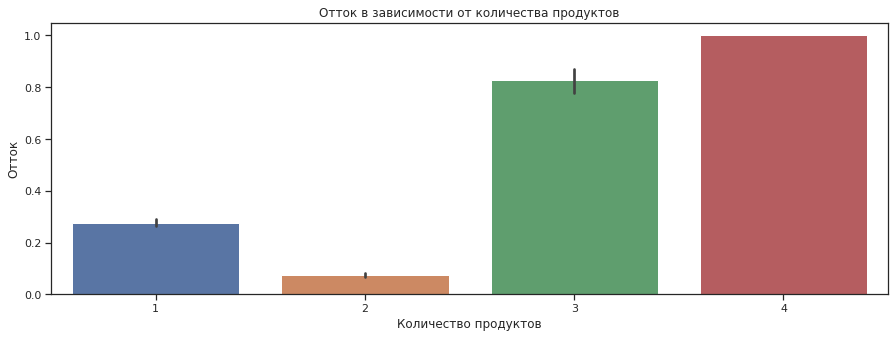

In [116]:
plt.figure(figsize=(15, 5))
plt.grid = True

sns.barplot(data=bank_data, x='products', y='churn')

plt.title('Отток в зависимости от количества продуктов',fontsize=12)

plt.xlabel('Количество продуктов', fontsize=12)
plt.ylabel('Отток',fontsize=12)
plt.show()

In [117]:
product_1.mean()

0.27714398111723054

In [118]:
product_more_1.mean()

0.1277461350691619

In [119]:
bank_data_churn = pd.DataFrame({'Клиенты с 1 продуктом': [product_1.mean()], 
     'Клиенты с несколькими продуктами': [product_more_1.mean()]})
bank_data_churn

,Клиенты с 1 продуктом,Клиенты с несколькими продуктами
0,0.28,0.13


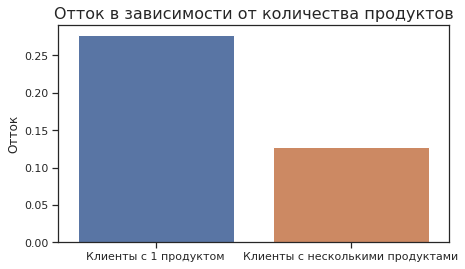

In [120]:
plt.figure(figsize=(7, 4))
sns.barplot(data=bank_data_churn)
plt.title('Отток в зависимости от количества продуктов',fontsize=16)
plt.ylabel('Отток',fontsize=12)
plt.show()

**Вывод**: Между выборками есть существенное отличие, поэтому мы отвергаем нулевую гипотезу. Проверка гипотезы показала, что есть статистические значимые отличия между оттоком клиентов с 1 продуком и несколькими продуктами. Отток клиентов, которые пользуются несколькими продуктами, существенно ниже. Такой результат получен в основном из-за того, что в группе клиентов с мультипродуктами в основном клиенты с 2-мя продуктами, доли клиентов с 3мя и 4мя продуктами ниже. Желательно иметь больше данных о клиентах с 3-4 продуктами.

## Выводы и рекомендации

### Результаты исследования

* Исследовательский анализ данных показал, что: 
 * Кредитный скоринг распределен близко к нормальному, в основном клиенты имеют среднее значение 650-700 баллов.
 * Количество клиентов с 1-2 продуктами намного больше, чем с 3-4 продуктами.
 * Большая часть клиентов имеет кредитные карты.
 * По лояльности клиенты разделены примерно поровну.
 * В датасете равномерно представлены клиенты с разным уровнем зарплат.



* В результате сегментации были установлены группы клиентов:
    * **Первый и второй сегмент**:
         * Количество банковских продуктов: 1-2,
         * Пол – женский,
         * Отток – 0,
         * Лояльность – 1.

 * **Третий и четвертый сегмент**:
       * Количество банковских продуктов: 3-4,
       * Пол – мужской,
       * Отток – 1,
       * Лояльность – 0.
Остальные характеристики между сегментами похожи. 



* Проверка гипотез показала следующее:
  * средний доход клиентов с 1 и 2 продуктами не отличается,
  *  есть статистические значимые отличия между оттоком клиентов с 1 продуктом и несколькими продуктами. Отток пользователей с 1-м продуктом ниже.

Клиенты с 3-мя продуктами подвержены высокому оттоку. Возможно, у банка есть 1-2 хороших продукта (например, дебетовые/ кредитные карты), остальные продукты пользователям не нравятся.
  

### Рекомендации для бизнеса

Так как клиенты с большим количеством продуктов подвержены высокому оттоку, то было предположение, что у банка есть 1-2 хороших продукта (например, дебетовые/ кредитные карты), остальные продукты пользователям не нравятся.

Рекомендуется совершенствовать новые виды банковских продуктов, проводить опросы среди клиентов для выявления их потребностей,  повышая уровень их удовлетворенности, чтобы избежать оттока.  Для клиентов с высоким уровнем дохода можно предложить инвестиционные продукты, которые оправдают их ожидания. Для обладателей кредитных карт можно предлагать кредиты с льготной ставкой и др. Текущие дополнительные продукты клиентам не нравятся, и их следует существенно доработать.



### Баг-репорт

* Странно, что размер баланса на дебетовой карте (накопления) не зависят от уровня заработной платы.
* Недостаток временных логов (ограниченность датасета) для более полного и глубокого анализа.
* У клиентов в оттоке ненулевой баланс.
* Желательно иметь больше данных о клиентах с 3-4 продуктами.